In [1]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('data_01.csv')
df2 = pd.read_csv('data_02.csv')
df3 = pd.read_csv('data_03.csv')
df4 = pd.read_csv('data_04.csv')
df5 = pd.read_csv('data_05.csv')
df6 = pd.read_csv('data_06.csv')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 46 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


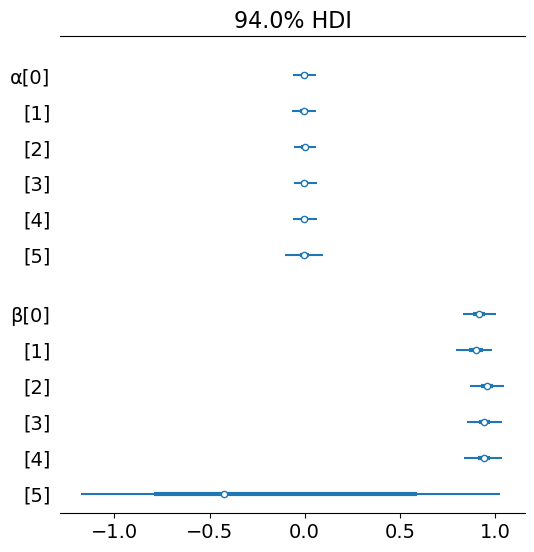

In [3]:
#Предполагается, что у нас имеются следующие данные
datasets = [df1, df2, df3, df4, df5, df6]

# Мы используем стандартизированные значения x и y для упрощения обработки
idd = []
for i, d in enumerate(datasets):
    datasets[i]['x'] = (d['x'] - d['x'].mean()) / d['x'].std()
    datasets[i]['y'] = (d['y'] - d['y'].mean()) / d['y'].std()
    idd.extend([i] * len(d))

x_m = np.concatenate([d['x'] for d in datasets])
y_m = np.concatenate([d['y'] for d in datasets])
M = len(datasets)

with pm.Model() as hierarchical_model:
    # априорные гипер-распределения
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=5)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=5)
    β_μ = pm.Normal('β_μ', mu=0, sigma=1)
    β_σ = pm.HalfNormal('β_σ', sigma=1)

    # априорные распеределения
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=M)
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    # апосториорное распределение
    y_pred = pm.StudentT('y_pred', mu=α_tmp[idd] + β[idd] * x_m,
    sigma=ε, nu=ν, observed=y_m)

    # обратное перемасштабирование
    α = pm.Deterministic('α', α_tmp - β * x_m.mean())
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * x_m.mean())
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * x_m.mean())

    # трассировка
    trace_hm = pm.sample(3000, tune=1000, target_accept=.8)

az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);


array([[<Axes: title={'center': 'α_μ_tmp'}>,
        <Axes: title={'center': 'α_μ_tmp'}>],
       [<Axes: title={'center': 'β_μ'}>, <Axes: title={'center': 'β_μ'}>],
       [<Axes: title={'center': 'α_tmp'}>,
        <Axes: title={'center': 'α_tmp'}>],
       [<Axes: title={'center': 'β'}>, <Axes: title={'center': 'β'}>],
       [<Axes: title={'center': 'α_σ_tmp'}>,
        <Axes: title={'center': 'α_σ_tmp'}>],
       [<Axes: title={'center': 'β_σ'}>, <Axes: title={'center': 'β_σ'}>],
       [<Axes: title={'center': 'ε'}>, <Axes: title={'center': 'ε'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'α_μ'}>, <Axes: title={'center': 'α_μ'}>],
       [<Axes: title={'center': 'α_sd'}>,
        <Axes: title={'center': 'α_sd'}>]], dtype=object)

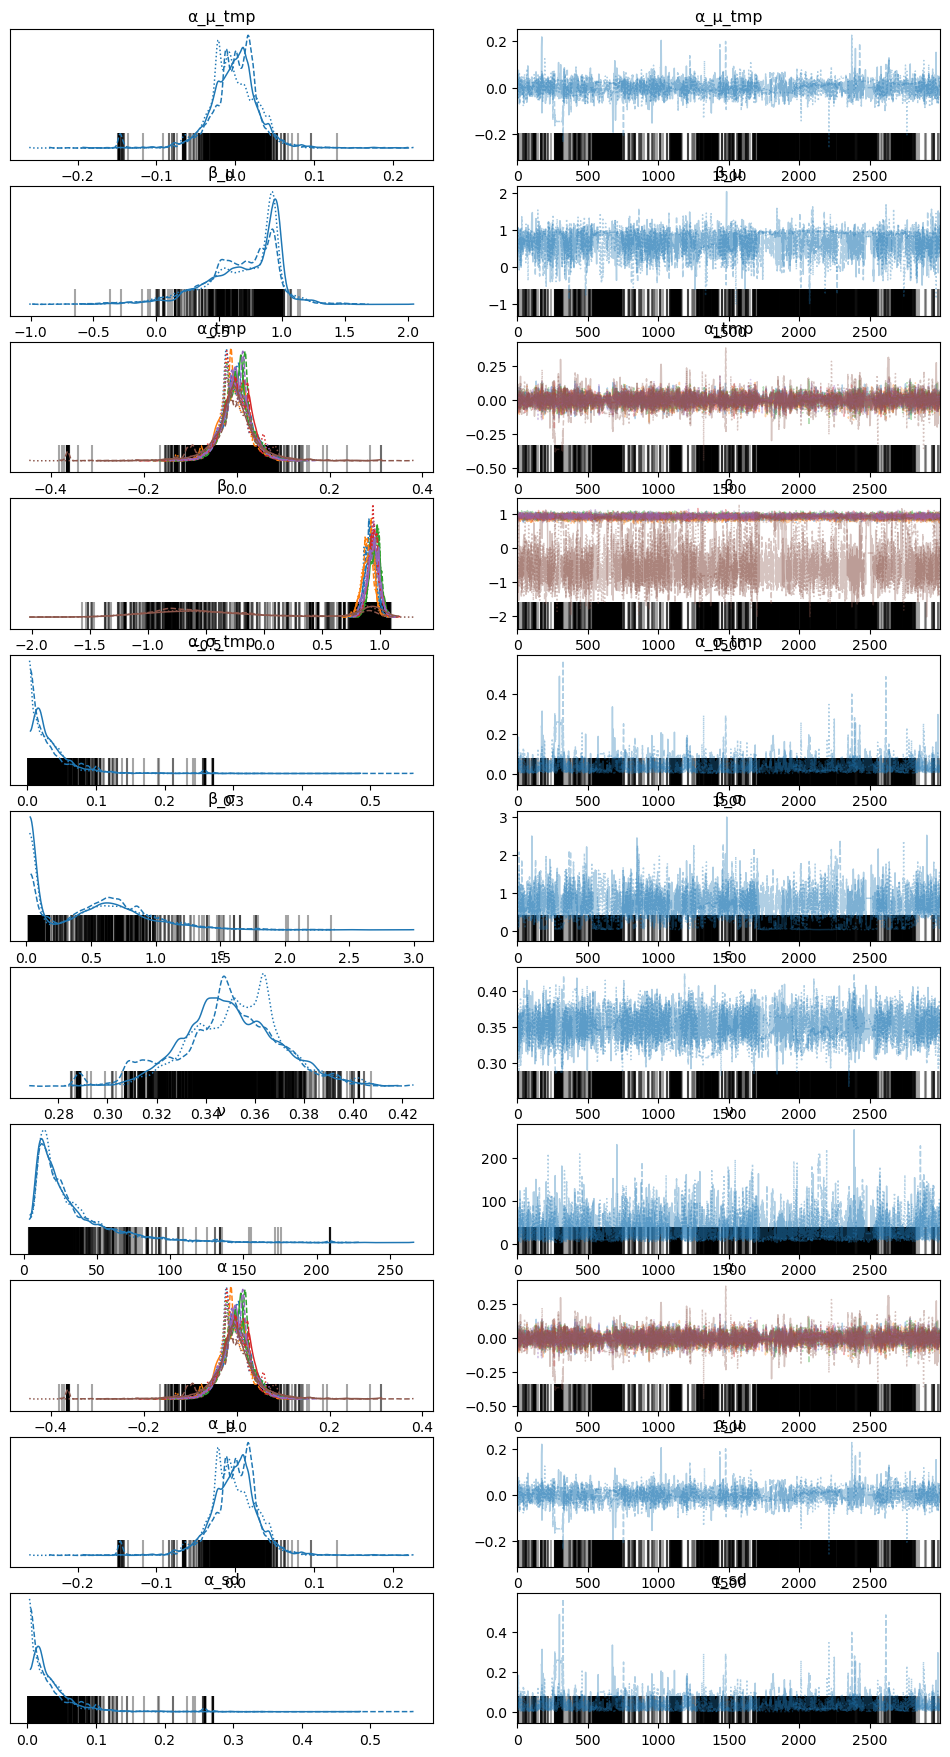

In [4]:
az.plot_trace(trace_hm)

In [5]:
az.summary(trace_hm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_μ_tmp,-0.002,0.032,-0.060,0.054,0.001,0.001,656.0,667.0,1.01
β_μ,0.686,0.307,-0.002,1.093,0.017,0.014,220.0,1997.0,1.01
α_tmp[0],-0.001,0.031,-0.060,0.059,0.001,0.001,1224.0,2573.0,1.00
α_tmp[1],-0.005,0.033,-0.067,0.062,0.001,0.001,762.0,836.0,1.00
α_tmp[2],0.000,0.031,-0.059,0.061,0.001,0.001,1237.0,1204.0,1.01
α_tmp[3],-0.001,0.031,-0.057,0.063,0.001,0.001,604.0,528.0,1.00
α_tmp[4],-0.001,0.033,-0.060,0.067,0.001,0.001,1022.0,819.0,1.00
α_tmp[5],-0.006,0.059,-0.106,0.095,0.003,0.003,487.0,182.0,1.01
β[0],0.917,0.048,0.829,1.006,0.003,0.002,327.0,1961.0,1.01
β[1],0.898,0.051,0.796,0.985,0.003,0.002,336.0,1947.0,1.01


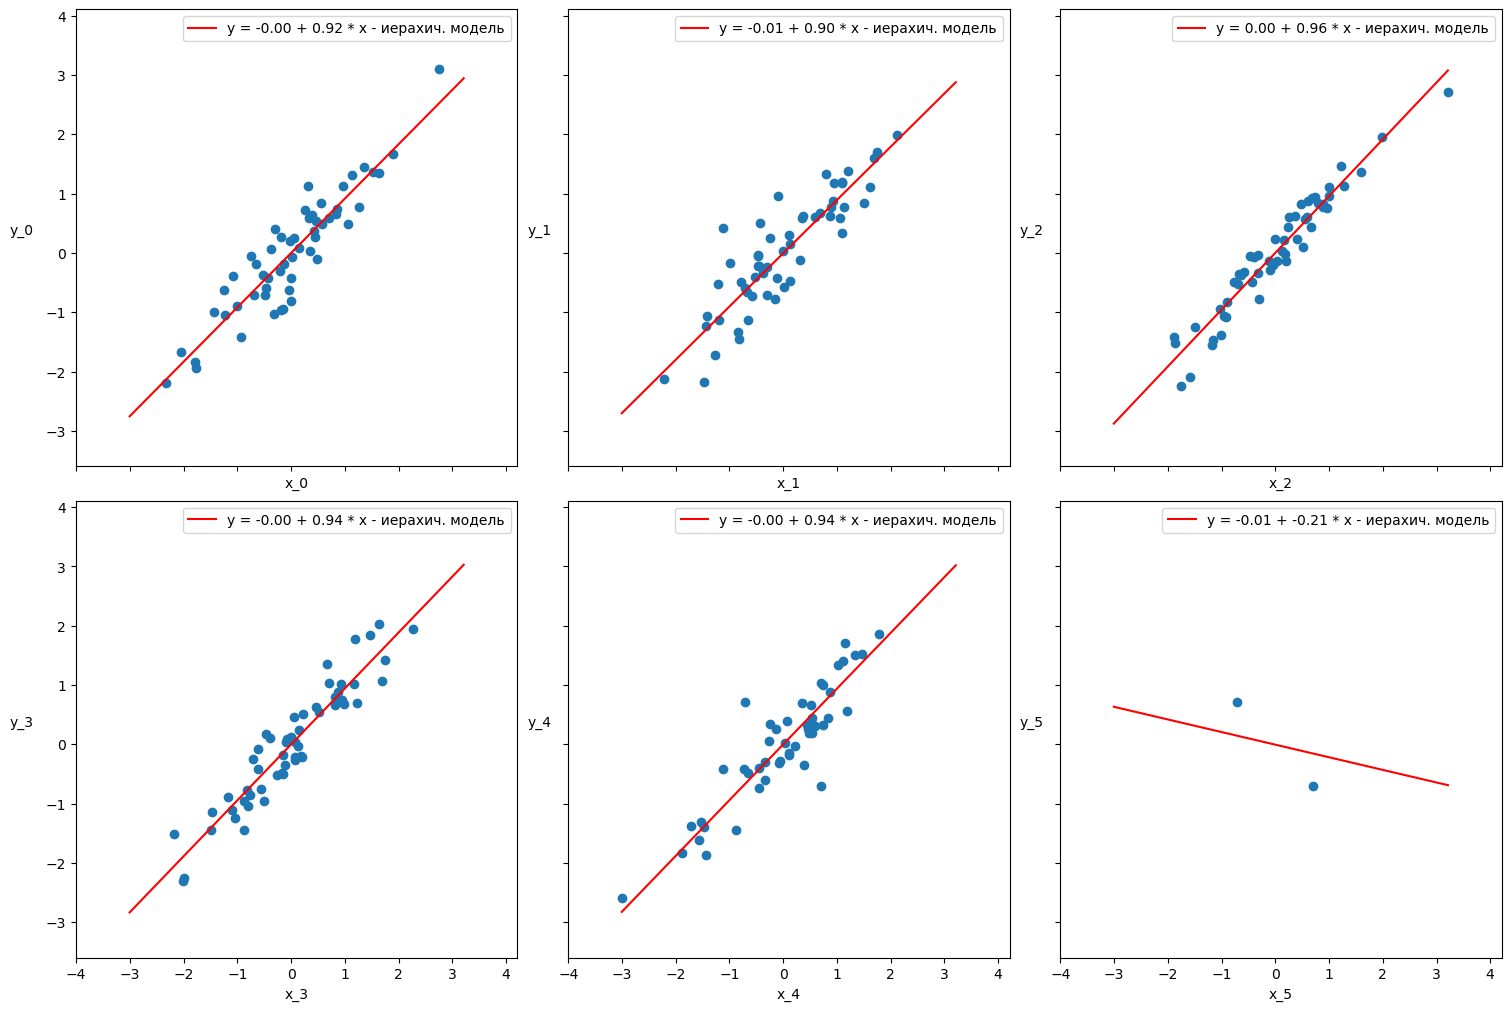

In [6]:
_, ax = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True,
                     constrained_layout=True)

trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})


ax = np.ravel(ax)
j, k = 0, len(df1)
x_range = np.linspace(x_m.min(), x_m.max(), 10)

for i in range(M):
    N = len(datasets[i])
    ax[i].scatter(x_m[j:k], y_m[j:k])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    alpha_m = trace_hmm['α'].sel({'α_dim_0':i}).mean().item()
    beta_m  = trace_hmm['β'].sel({'β_dim_0':i}).mean().item()
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c='r',
               label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x'+' - иерахич. модель')


    ax[i].legend()
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N

In [7]:
len(df1)

55